It has been a little over three years since I started working on a [Python
implementation of the Hilbert Huang
Transform](http://github.com/jaidevd/pyhht). When I first presented it at SciPy
India 2011
([video](http://urtalk.kpoint.com/kapsule/gcc-57b6c86b-2f12-4244-950c-a34360a2cc1f/t/hilberthuang-transform))
it was just a collection of small scripts, without packaging, testing or even
docstrings. Over time PyHHT has garnered some interest, and I have, since the
last few weeks, found the time to regularly work on it. I have been able to
come up with a decent implementation of [empirical mode
decomposition](http://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform),
pretty much in line with everything described in the [original
paper](http://tec.earth.sinica.edu.tw/research/report/paper/20070711HHT.pdf) by Huang et
al. The other
parts of HHT, like the Hilbert spectrum and its time frequency representations
are right around the corner.
<!-- TEASER_END -->

This blogpost, and many more that will follow, will hopefully help me track the
progress of PyHHT. Who knows, doing this might even help me with the
documentaiton later on. Currently PyHHT is under heavy development, and I cannot comment on either the
stability or the correctness of the entire Python module. However, early on when developing
more sohpisticated modules, I realized that it would have to be very modular,
so as to enable better and more fine-tuned testing. The library is organized
primarily into three modules:

1. pyhht.emd - The main classes and functions that perform EMD.
2. pyhht.utils - miscellaneous utility functions that help the EMD algorithms.
3. pyhht.visualization - pretty plotting for IMFs (and for the Hilbert spectrum, coming soon.)

Out of this, the EMD algorithm itself is fairly straightforward. Although it does have a
lot of heuristics that make its results more "reasonable". As an example of
these heuristics, this post discusses the effects that boundary conditions of
the EMD algorithm might have on the resulting [intrinsic mode functions
](http://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform#Intrinsic_Mode_Functions_.28IMF.29).

Let us constuct a simple signal with two pure sinusoids with consummate
frequencies:

$$ s(t) = \sin (2\pi f_{1}t) + \sin (2\pi f_{2}t) $$

where $f_{1} = 10 Hz$ and $f_{2} = 5 Hz$

To highlight the idea of how EMD processes the residue (or the trend) in a
signal, let's add a linear ramp to the signal. (For the sake of simplicity,
let's just add the timestamps to the signal.)


In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10.0, 8.0)

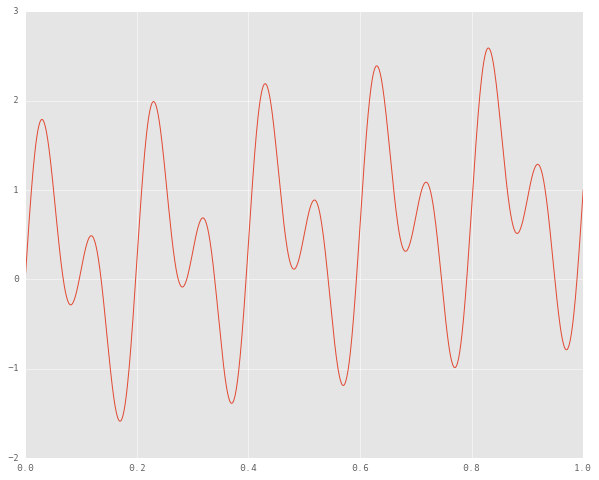

In [6]:
n_points = 1000
f1, f2 = 5, 10
time_samples = np.linspace(0, 1, n_points)
mode1 = np.sin(2 * np.pi * f1 * time_samples)
mode2 = np.sin(2 * np.pi * f2 * time_samples)
trend = time_samples

signal = mode1 + mode2 + trend

plt.plot(time_samples, signal)

We would expect an ideal EMD algorithm to produce two IMFs, one corresponding to each of our unimodal signals, and then to extract the residue too. Let's write a naive sifting loop.

In [7]:
from scipy.signal import argrelmin, argrelmax
from scipy.interpolate import splrep, splev

tol = 0.05

def ndiff_extrema_zcrossing(x):
    """Get the difference between the number of zero crossings and extrema."""
    n_max = argrelmax(x)[0].shape[0]
    n_min = argrelmin(x)[0].shape[0]
    n_zeros = (x[:-1] * x[1:] < 0).sum()
    return abs((n_max + n_min) - n_zeros)


def sift(x):
    """One sifting iteration."""
    maxima = argrelmax(x)[0]
    minima = argrelmin(x)[0]
    x_upper = np.zeros((maxima.shape[0] + 2,))
    x_upper[1:-1] = maxima
    x_upper[-1] = x.shape[0] - 1
    x_lower = np.zeros((minima.shape[0] + 2,))
    x_lower[1:-1] = minima
    x_lower[-1] = x.shape[0] - 1
    tck = splrep(x_upper, x[x_upper.astype(int)])
    upper_envelop = splev(np.arange(x.shape[0]), tck)
    tck = splrep(x_lower, x[x_lower.astype(int)])
    lower_envelop = splev(np.arange(x.shape[0]), tck)
    mean_amplitude = np.abs(upper_envelop - lower_envelop) / 2
    local_mean = (upper_envelop + lower_envelop) / 2
    amplitude_error = np.abs(local_mean) / mean_amplitude
    return x - local_mean, amplitude_error.sum()


def emd(x, n_imfs):
    imfs = np.zeros((n_imfs + 1, x.shape[0]))
    for i in xrange(n_imfs):
        mode = x - imfs.sum(0)
        while (ndiff_extrema_zcrossing(mode) > 1):
            mode, amplitude_error = sift(mode)
            if amplitude_error <= tol:
                break
        imfs[i, :] = mode
    imfs[-1, :] = x - imfs.sum(0)
    return imfs

Let's extract and visualize the IMFs to see if they meet our expectations.

/Users/jaidevd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in divide


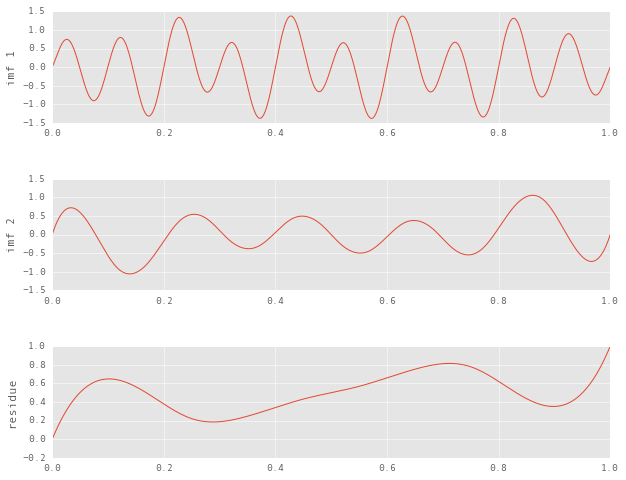

In [8]:
n_imfs = 2
imfs = emd(signal, n_imfs)
plt.subplot(n_imfs + 1, 1, n_imfs + 1), plt.plot(time_samples, imfs[-1, :]), plt.ylabel('residue')
for i in range(n_imfs):
    plt.subplot(n_imfs + 1, 1, i + 1), plt.plot(time_samples, imfs[i, :])
    plt.ylabel('imf {}'.format(i + 1))

On closer inspection of the residue, it seems like it contains the true residue (the ramp) superimposed on an IMF that we haven't yet sifted out. Let's see what happens when we increment the expected number of IMFs.

/Users/jaidevd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in divide


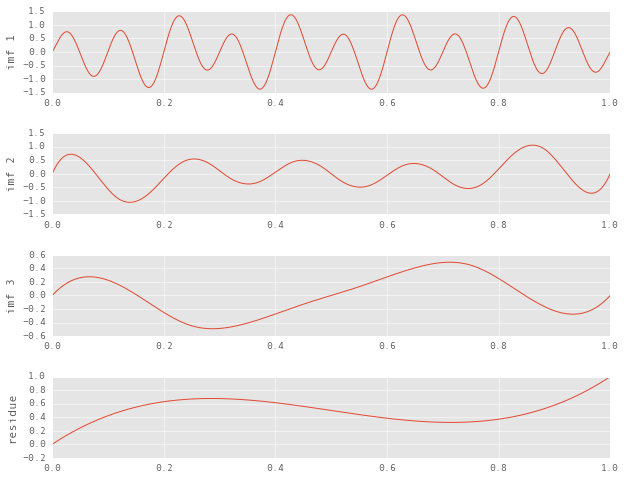

In [9]:
n_imfs = 3
imfs = emd(signal, n_imfs)
plt.subplot(n_imfs + 1, 1, n_imfs + 1), plt.plot(time_samples, imfs[-1, :]), plt.ylabel('residue')
for i in range(n_imfs):
    plt.subplot(n_imfs + 1, 1, i + 1), plt.plot(time_samples, imfs[i, :])
    plt.ylabel('imf {}'.format(i + 1))

We've finally reached a stopping point beyond which sifting is not possible. While the decomposition itself is valid, the inferences we draw from it can be quite misleading. In a broad sense, here is what is wrong with the decomposition:

1. Qualitatively, the residue is supposed to be a somewhat linear, monotonically increasing function.
2. The number if IMFs should be two.
3. The IMFs should at least appear to be pure sinudoids.

To get to the heart of the problem, let's go back to our original signal and try to step through the sifting process. The first thing we do to an input signal is to construct upper and lower envelopes by interpolating with cubic splines its local maxima and local minima respectively, and then subtracting the mean of these envelopes from the signal.

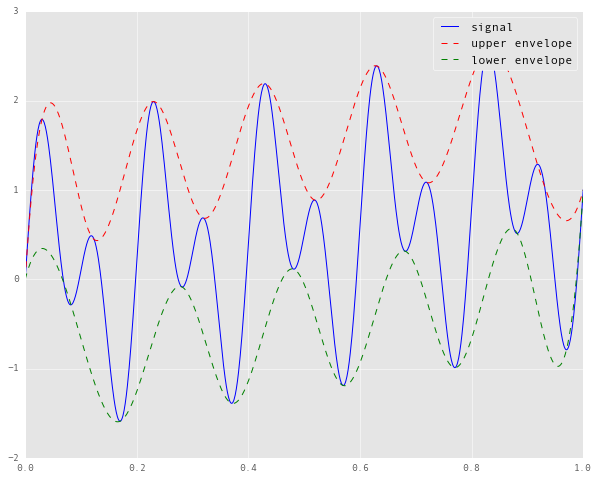

In [10]:
def get_envelopes(x):
    """Compute the upper and lower envelopes of a signal."""
    maxima = argrelmax(x)[0]
    minima = argrelmin(x)[0]
    x_upper = np.zeros((maxima.shape[0] + 2,))
    x_upper[1:-1] = maxima
    x_upper[-1] = x.shape[0] - 1
    x_lower = np.zeros((minima.shape[0] + 2,))
    x_lower[1:-1] = minima
    x_lower[-1] = x.shape[0] - 1
    tck = splrep(x_upper, x[x_upper.astype(int)])
    upper_envelop = splev(np.arange(x.shape[0]), tck)
    tck = splrep(x_lower, x[x_lower.astype(int)])
    lower_envelop = splev(np.arange(x.shape[0]), tck)
    return upper_envelop, lower_envelop

upper, lower = get_envelopes(signal)
plt.plot(time_samples, signal, 'b', label='signal')
plt.plot(time_samples, upper, 'r--', label='upper envelope')
plt.plot(time_samples, lower, 'g--', label='lower envelope')
plt.legend()

If we zoom in on the left and right edges of the plot, here's what we see.

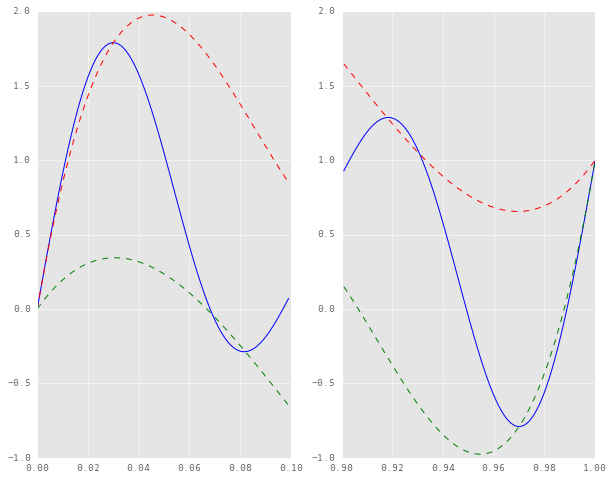

In [11]:
plt.subplot(121)
plt.plot(time_samples[:100], signal[:100], 'b',
         time_samples[:100], upper[:100], 'r--', time_samples[:100], lower[:100], 'g--')
plt.subplot(122)
plt.plot(time_samples[900:], signal[900:], 'b',
         time_samples[900:], upper[900:], 'r--', time_samples[900:], lower[900:], 'g--')

It turns out that the envelopes constructed here are not _true_ envelopes, in that the signal is leaking out of their bounds. This is because the naive interpolation method assumes the endpoints of the signal to be knots in the interpolation. Consequently, the splines cannot numerically "compensate" for the slope of the signal near the endpoints.

But if we don't consider the endpoints of the signals as the endpoints of the splines, what is the alternative? It's not like we have any more data, so we just make some. The solution, simply put, consists of:

1. selecting $k$ maxima and $k$ minima closest to each endpoint, and extending them symmetrically beyond the edges,
2. constructing the upper and lower envelopes with these extended extrema
3. slicing off these envelopes with the indices of the original signal

This is how it looks when $k = 2$:

In [12]:
from pyhht.utils import boundary_conditions
tmin, tmax, xmin, xmax = boundary_conditions(signal, time_samples, nbsym=2)

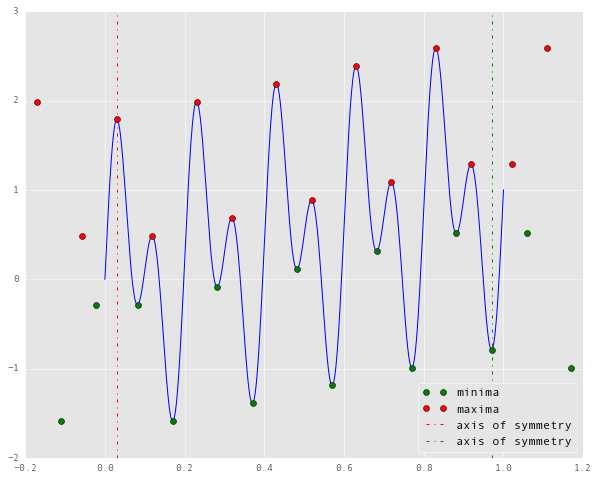

In [13]:
plt.plot(time_samples, signal, 'b')
plt.plot(tmin, xmin, 'go', label='minima')
plt.plot(tmax, xmax, 'ro', label='maxima')
plt.vlines(tmax[2], -2, 3, 'r','dashdot', label='axis of symmetry')
plt.vlines(tmin[-3], -2, 3, 'g', 'dashdot', label='axis of symmetry')
plt.legend(loc=4)

The dotted lines represent the axes about which the extrapolated extrema are symmetric. Now we can use these new data points to reconstruct our envelopes, as follows.

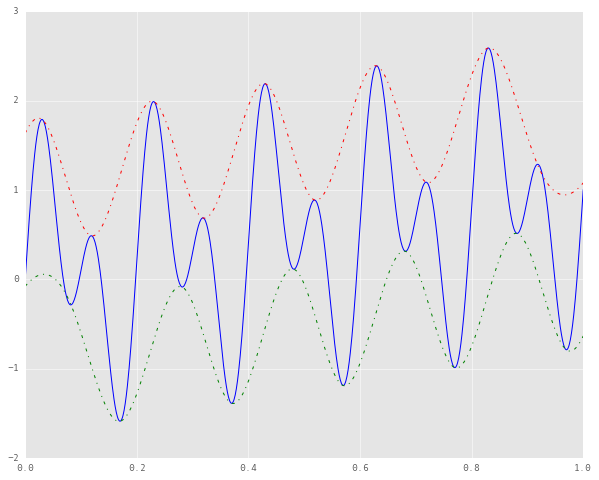

In [14]:
tck = splrep(tmin, xmin)
lower_env = splev(time_samples, tck)
tck = splrep(tmax, xmax)
upper_env = splev(time_samples, tck)

plt.plot(time_samples, signal, 'b')
plt.plot(time_samples, upper_env, 'r-.')
plt.plot(time_samples, lower_env, 'g-.')

It can be seen that the splines don't terminate at the endpoints of the signal itself. As before, here are the plots of the edges of this interpolation.

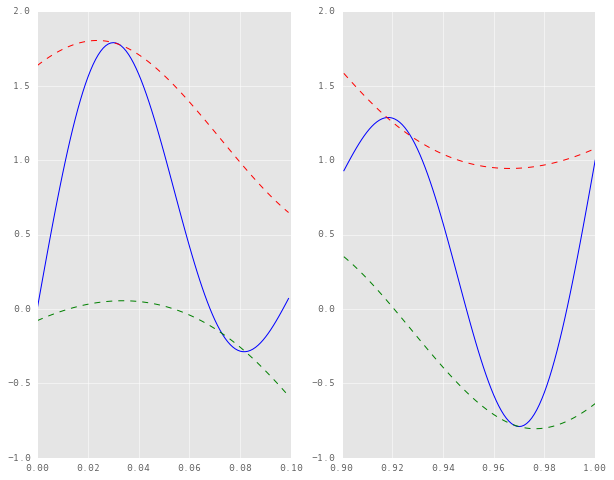

In [15]:
plt.subplot(121)
plt.plot(time_samples[:100], signal[:100], 'b',
         time_samples[:100], upper_env[:100], 'r--', time_samples[:100], lower_env[:100], 'g--')
plt.subplot(122)
plt.plot(time_samples[900:], signal[900:], 'b',
         time_samples[900:], upper_env[900:], 'r--', time_samples[900:], lower_env[900:], 'g--')

The "leakage" of the signal beyond the envelopes is far less drastic, and we're much closer to a _true_ envelope now. It's still not a perfect envelope, but I'm not entirely sure on whether that is a function of the sampling rate (I doubt it) or the order of symmetry, or anything else. I suspect it might have to do with the the degree of the interpolating polynomial. Perhaps a higher order polynomial might eliminate this little leakage, but I'm sure it won't work well for the rest of the signal, the bulk of which is far more critical to the decomposition. Anyhow, let's see how EMD fares with this added heuristic. For this we will have to redefine the `sift` and `emd` functions from before.

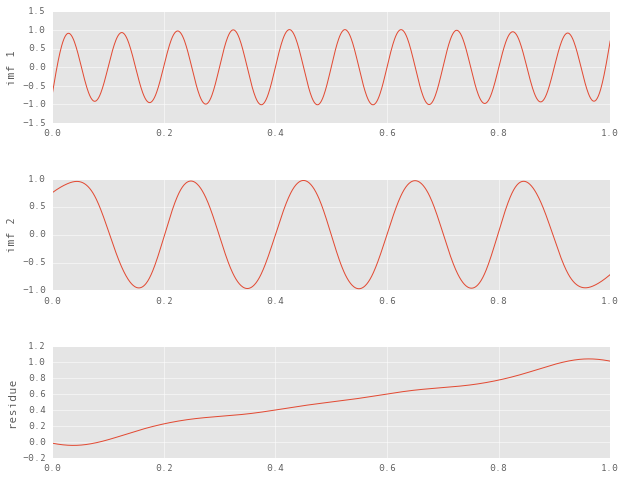

In [16]:
from pyhht.utils import extr


def sift(x, ts):
    """One sifting iteration."""
    tmin, tmax, xmin, xmax = boundary_conditions(x, ts)
    tck = splrep(tmin, xmin)
    lower_envelop = splev(ts, tck)
    tck = splrep(tmax, xmax)
    upper_envelop = splev(ts, tck)
    mean_amplitude = np.abs(upper_envelop - lower_envelop) / 2
    local_mean = (upper_envelop + lower_envelop) / 2
    amplitude_error = np.abs(local_mean) / mean_amplitude
    return x - local_mean, amplitude_error.sum()


def emd(x, ts, n_imfs):
    imfs = np.zeros((n_imfs + 1, x.shape[0]))
    for i in xrange(n_imfs):
        ix = 0
        mode = x - imfs.sum(0)
        nmin, nmax, nzero = map(len, extr(mode))
        while abs((nmin + nmax) - nzero) > 1:
            mode, amplitude_error = sift(mode, ts)
            if amplitude_error <= tol:
                break
        imfs[i, :] = mode
    imfs[-1, :] = x - imfs.sum(0)
    return imfs


n_imfs = 2
imfs = emd(signal, time_samples, n_imfs=n_imfs)
plt.subplot(n_imfs + 1, 1, n_imfs + 1), plt.plot(time_samples, imfs[-1, :]), plt.ylabel('residue')
for i in range(n_imfs):
    plt.subplot(n_imfs + 1, 1, i + 1), plt.plot(time_samples, imfs[i, :])
    plt.ylabel('imf {}'.format(i + 1))

This decomposition is a clearly better approximation of the original components. You can easily tell the two unimodal components from earlier, and even the residue is much closer to the linear trend that we had included in the signal.

The interesting thing to note here is that this signal was very straightforward, and even then the edge effects of sifting were severe. There's no telling how these might affect the decomposition of real world data.

There are many more heuristics involved in a good implementation of empirical mode decomposition. Following posts will deal with them in more detail.